In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bte
import datetime as dt

SARS-CoV-2 is often characterized by bursts of closely related infections in a short span of time, reflecting events where a single infected individual is exposed to a large number of vulnerable individuals. We can identify these within the phylogeny by identifying nodes with large groups of identical or near-identical samples. 

In [2]:
mat = bte.MATree("public-2022-04-08.all.masked.nextclade.pangolin.pb.gz")

Finished 'from_pb' in 28.8859 seconds


Let's define a superspreader event here as the top 1% of groups of samples with a shared parent. This is not truly informed, given inherent variation in sequencing rate across regions and times, but is sufficient for an initial survey of the data.

In [3]:
groups = {}
cp = None
clist = []
for n in mat.breadth_first_expansion():
    if n.is_leaf() and len(n.mutations) <= 1:
        if n.parent.id != cp:
            if cp != None:
                groups[cp] = clist
            cp = n.parent.id
            clist = [n]
        else:
            clist.append(n)

Finished 'breadth_first_expansion' in 0.6687 seconds


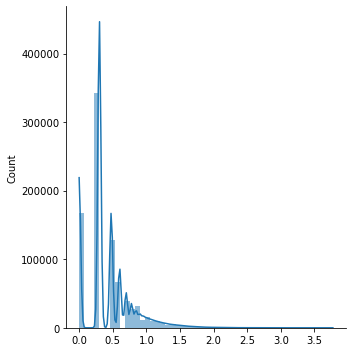

In [4]:
sns.displot(kde=True, bins=50, data=[np.log10(len(v)) for v in groups.values()], edgecolor=None)

In [5]:
threshold = np.percentile([len(v) for v in groups.values()],99)
threshold, len([len(v) for v in groups.values() if len(v) > threshold])

(42.0, 8606)

Under this definition, we have highlighted 8,606 putative superspreader events, with 42 or more infections with less than 1 mutation distinguishing them. With a sampling rate of less than 5% of positive tests in most areas, it's likely that these events are associated with bursts of hundreds to thousands of infections within less than a month.

In [6]:
samples, count = max([(v,len(v)) for v in groups.values()],key=lambda x:x[1])
count

5945

Our very largest group is nearly six thousand extremely similar samples. Let's take a closer look at these samples. Where are they from? And when were they collected?

Fortunately, there is a standardized format for sample names for SARS-CoV-2 uploaded to public repositories. Generally, the name starts with the country ID followed by a "/" character, and ends with the date in Y-M-D format after a "|" character. We can therefore extract date and location from sample IDs.

In [7]:
sdf = {k:[] for k in ['Country','Date','Mutations','Annotations']}
for s in samples:
    sdf['Country'].append(s.id.split("/")[0])
    try:
        sdf['Date'].append(dt.datetime.strptime(s.id.split("|")[-1],"%Y-%m-%d"))
    except:
        sdf['Date'].append(np.nan)
    sdf['Mutations'].append(len(s.mutations))
    sdf['Annotations'].append(s.annotations[1])
sdf = pd.DataFrame(sdf)
sdf

,Country,Date,Mutations,Annotations
0,England,2021-04-26,1,AY.4
1,England,2021-04-27,1,AY.4
2,England,2021-05-07,1,AY.4
3,England,2021-04-28,1,AY.4
4,England,2021-05-10,1,AY.4
...,...,...,...,...
5940,England,2021-06-10,0,AY.4
5941,Scotland,2021-06-25,0,AY.4
5942,Scotland,2021-06-26,0,AY.4
5943,Scotland,2021-07-27,0,AY.4


In [8]:
sdf.Country.value_counts()

England                                                                      5454
Wales                                                                         180
Scotland                                                                      163
Northern_Ireland                                                               70
NorthernIreland                                                                41
Switzerland                                                                    14
USA                                                                             9
IMS-10150-CVDP-84063865-DB50-40B0-A333-6C2193AE73AD|OU617366.1|2021-08-10       1
Molecular_surveillance_of_SARS-CoV-2_in_Germany|OV261337.1|2021-08-12           1
RNA|OV103593.1|2021-09-03                                                       1
RNA|OV103874.1|2021-08-24                                                       1
IMS-10150-CVDP-D804765E-94AF-4563-AE51-3549A2A4A5DC|OU427632.1|2021-06-29       1
IMS-10150-CVDP-5

<AxesSubplot:xlabel='Date,Date'>

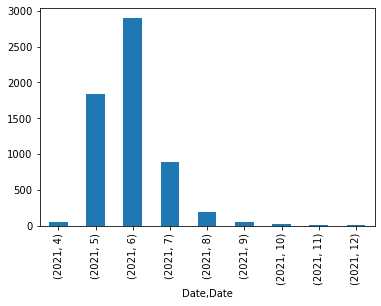

In [9]:
sdf.Date.groupby([sdf['Date'].dt.year,sdf['Date'].dt.month]).count().plot(kind="bar")

This superspreader event appears to be centered within the United Kingdom, with spread primarily in England but also to Wales, Scotland, and Northern Ireland. There are also a few samples appearing in the USA, Switzerland, and Germany. Note the inconsistent labeling of Northern_Ireland versus NorthernIreland- these kinds of data quality issues are pervasive and should be watched for.

AY.4 is a common sublineage of Delta. These samples are all collected over a period of about 2 months, from May 2021 to July 2021. It's likely that this group reflects one of the initial major waves of infection during the initial emergence of the Delta variant. 

In [10]:
cdf = {k:[] for k in ['MedianDate','PrimaryLocation','Count','Annotation']}
for g in [v for v in groups.values() if len(v) > threshold]:
    dates = []
    locs = {}
    annotes = {}
    count = 0
    for s in g:
        try:
            dates.append(dt.datetime.strptime(s.id.split("|")[-1],"%Y-%m-%d"))
            count += 1
            loc = s.id.split("/")[0]
            if loc not in locs:
                locs[loc] = 0
            locs[loc] += 1
            ann = s.annotations[1]
            if ann not in annotes:
                annotes[ann] = 0
            annotes[ann] += 1
        except:
            continue
    try:
        cdf['PrimaryLocation'].append(max([(l,c) for l,c in locs.items()],key=lambda x:x[1])[0])
        cdf['Annotation'].append(max([(l,c) for l,c in annotes.items()],key=lambda x:x[1])[0])
    except:
        continue
    cdf['MedianDate'].append(pd.Series(dates).quantile(0.5, interpolation="midpoint"))
    cdf['Count'].append(count)
cdf = pd.DataFrame(cdf)
cdf

,MedianDate,PrimaryLocation,Count,Annotation
0,2020-02-17 00:00:00,England,188,B
1,2020-03-06 00:00:00,England,92,B.55
2,2020-02-08 00:00:00,England,44,B
3,2020-03-23 00:00:00,USA,79,B
4,2020-03-12 00:00:00,Netherlands,83,B.11
...,...,...,...,...
8600,2021-11-30 00:00:00,England,211,AY.34.1
8601,2021-10-24 00:00:00,USA,44,AY.3.1
8602,2021-11-06 00:00:00,USA,49,AY.39
8603,2021-11-20 12:00:00,England,46,AY.4.2.1


<AxesSubplot:xlabel='MedianDate,MedianDate'>

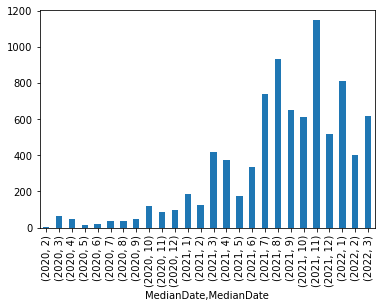

In [11]:
cdf.MedianDate.groupby([cdf['MedianDate'].dt.year,cdf['MedianDate'].dt.month]).count().plot(kind="bar")

The bulk of our detections occur in 2021. These are essentially correlated with total sequencing effort, since we're not correcting for the amount of sequencing available at any given time and the impact of that on final group sizes. 

In [12]:
cdf.PrimaryLocation.value_counts()[:15]

England             4278
USA                 2537
Scotland             633
Wales                461
Switzerland          190
Denmark              125
Northern_Ireland      91
Germany               61
AUS                   40
Iceland               10
DEU                    8
NorthernIreland        6
Japan                  6
BHR                    5
HKG                    5
Name: PrimaryLocation, dtype: int64

Similarly, the locations we identify are most commonly England and the USA, as that is the source of the bulk of our sequencing. 

In [13]:
cdf[(cdf.MedianDate > dt.datetime(year=2022,month=3,day=1)) & (cdf.PrimaryLocation == "USA")].Annotation.value_counts()

BA.2         6
BA.2.7       3
BA.2.9       3
BA.1.1       2
BA.2.12      2
BA.2.3       1
BA.2.10      1
BA.2.12.1    1
Name: Annotation, dtype: int64

Among superspreader events in March 2022 in the USA, they are all variants on Omicron, predictably enough.